In [70]:
# this assumes torque at the rotation

In [118]:
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from pydrake.math import sin, cos
import time

%matplotlib inline

from pydrake.all import (SignalLogger, CompliantMaterial, ConstantVectorSource, DirectCollocation, DiagramBuilder, FloatingBaseType,
                         PiecewisePolynomial, RigidBodyTree, RigidBodyPlant,
                         SolutionResult, AddModelInstancesFromSdfString,
                         MathematicalProgram, Simulator, BasicVector, AddFlatTerrainToWorld)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

In [2]:
# using meschat as the visualizer
import meshcat
import meshcat.geometry as g
import meshcat.transformations as tf

In [3]:
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [93]:
# define dynamical properties of the system
mass = 1.0
length = 1.0
gravity = 9.81
water_distance = .9 # distance from the top of the pendulum to the water
damping_coeff = .5

In [98]:
# create the objects
pivot = vis["pivot"]
pole = pivot["pole"]
water = vis["water"]

# draw the objects
pivot.set_object(g.Sphere(radius=.1)) # set pivot to be a sphere
pole.set_object(g.Cylinder(height=1.0,radius=.05)) # create cylinder to pivot

# position the objects
pole.set_transform(tf.translation_matrix([0,length/2.0,0])) # set location of pole
pivot.set_transform(tf.rotation_matrix(-np.pi/2.0,[1,0,0])) # rotate the pole

# position the water
water.set_object(g.Box([2,2,.01]))
water.set_transform(tf.translation_matrix([0,0,-water_distance]))

In [187]:
# states
theta = 0.0 # theta
theta_dot = 0.0 # theta derivative

state_initial = [theta, theta_dot] # initial state vector
def draw_transformation(state):
    pivot.set_transform(tf.rotation_matrix(state[0]-np.pi/2.0,[1,0,0])) # rotate the pole
draw_transformation(state_initial) # draw the initial state

In [188]:
# check if the pendulum is contact with water
def contact_check(state):
    return True
    theta = state[0]
    # check if theta is in the region
    if theta < .1:
        return True
    else:
        return False

In [189]:
# define the transition between states
def pend_guard(state):
    return True

In [190]:
# dyanmics with damping
def pend_contact(state, u):
    
    # include necessary parameters
    global mass, length, gravity, damping_coeff
    
    # unpack values
    theta = state[0]
    theta_dot = state[1]
    
    # set the derivative values
    derivs = np.zeros_like(state)
    derivs[0] = theta_dot # set theta_dot to theta_dot
    # dynamics of damped pendulum
    derivs[1] = -damping_coeff*theta_dot/(mass*length**2) + u[0]/(mass*length**2) - gravity*sin(theta)/length
    
    return derivs

In [191]:
def pend_no_contact(state, u):
    
    # include necessary parameters
    global mass, length, gravity, damping_coeff
    
    # unpack values
    theta = state[0]
    theta_dot = state[1]
    
    # set the derivative values
    derivs = np.zeros_like(state)
    derivs[0] = theta_dot # set theta_dot to theta_dot
    # dynamics of damped pendulum
    derivs[1] = u[0]/(mass*length**2) - gravity*sin(theta)/length
    
    return derivs

In [192]:
# get the dynamics
def pend_dynamics(state, u):
    if contact_check(state):
        return pend_contact(state,u)
    else:
        return pend_no_contact(state,u)

In [248]:
def compute_optimal_control(initial_state, final_state, min_time, max_time):
    # Setup solver
    mp = MathematicalProgram()

    # number knot points
    N = 50
    
    # Total time used
    time_used = mp.NewContinuousVariables(1, "time_used") # add random variabe for time used
    dt = time_used/(N+1)
    
    # Control decision variables
    u = mp.NewContinuousVariables(1, "u_%d" % 0) # only one input
    u_over_time = u
    for k in range(1,N):
        u = mp.NewContinuousVariables(1, "u_%d" % k)
        u_over_time = np.vstack((u_over_time, u))
    total_u = u_over_time

    # State decision variabless
    x = mp.NewContinuousVariables(2, "x_%d" % 0) # for both input thrusters
    x_over_time = x
    for k in range(1,N+1):
        x = mp.NewContinuousVariables(2, "x_%d" % k)
        x_over_time = np.vstack((x_over_time, x))
    total_x = x_over_time
    
    # State Constraints
    error_thresh = 0.0001
    for n in range(N):
        # Actual state vs. predicted (through dynamics) state
        state_next = total_x[n+1]
        dynamic_state_next = total_x[n,:] + pend_dynamics(total_x[n,:], total_u[n,:])*dt
  
        # Make sure the actual and predicted align to follow dynamics
        for j in range(2):
            state_error = state_next[j] - dynamic_state_next[j]
            mp.AddConstraint(state_error <= error_thresh)
            mp.AddConstraint(state_error >= -error_thresh)

    # Quadratic Cost in control effort
    # TODO: Make this cost of transport, better measure of effort
    # COT = u^2/(m_tot*g*d)
    mp.AddQuadraticCost(1 * u_over_time[:,0].dot(u_over_time[:,0]))

    # Add initial and final state constraints
    for i in range(2):
        # initial
        initial_state_error = x_over_time[0,i] - initial_state[i]
        mp.AddConstraint(initial_state_error == 0.0)
        
        # final
        final_state_error = x_over_time[-1,0] - final_state[0]
        mp.AddConstraint(final_state_error <= error_thresh)
        mp.AddConstraint(final_state_error >= -error_thresh)
        
        
        
    
#     # final constraints
#     theta_error = x_over_time[-1,0] - final_state[0]
#     mp.AddConstraint(theta_error <= error_thresh)
#     mp.AddConstraint(theta_error >= -error_thresh)
    
#     theta_dot_error = x_over_time[-1,1] - final_state[1]
#     mp.AddConstraint(theta_dot_error <= error_thresh)
#     mp.AddConstraint(theta_dot_error >= -error_thresh)
    
    # add time constraint
    mp.AddConstraint(time_used[0] >= minimum_time)
#     mp.AddConstraint(time_used[0] <= maximum_time)

    print "Number of decision vars", mp.num_vars()
    print(mp.Solve())

    trajectory = mp.GetSolution(x_over_time)
    input_trajectory = mp.GetSolution(u_over_time)
    t = mp.GetSolution(time_used)
    time_array = np.arange(0.0, t, t/(N+1))
    
    return trajectory, input_trajectory, time_array

In [249]:
# Different starting places
origin = (0.0,0.0) # theta, theta_dot

# Set the desired final conditions
swing_up = (np.pi,0.0)

# Set the time constraints
minimum_time = 0.5; maximum_time = 15.

# Solve the trajectory optimization
traj, input_traj, time_array = compute_optimal_control(origin, swing_up, minimum_time, maximum_time)


Number of decision vars 153
SolutionResult.kSolutionFound


In [250]:
# Print trajectory information
print "Trajectory size: ", traj.shape
print "Input size: ", input_traj.shape
print "\n"

# Print initial conditions
print "Initial state: ", traj[0]
print "\n"

# Print final conditionsa
print "Final state: ", traj[-1]

print "Final time: ", time_array[-1]
print "Total energ: ", input_traj.dot(input_traj)

Trajectory size:  (51, 2)
Input size:  (50,)


Initial state:  [0. 0.]


Final state:  [ 3.14149265e+00 -6.96727924e-04]
Final time:  13.4510003507421
Total energ:  1.2423777115930676e-08


In [251]:
def plot_theta(trajectory, time_array):
    theta = trajectory[:,0]
    fig, axes = plt.subplots(nrows=1, ncols=1)
    axes.plot(time_array, theta)
    plt.show()
    
def plot_u(input_trajectory, time_array):
    fig, axes = plt.subplots(nrows=1,ncols=1)
    axes.plot(time_array[:-1], input_trajectory)
    plt.show()

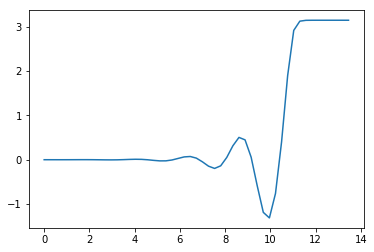

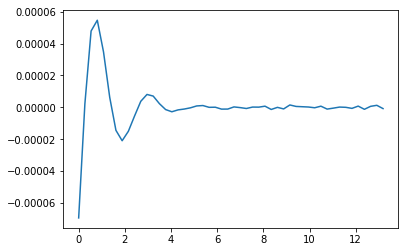

In [252]:
# Plot
plot_theta(traj, time_array)
plot_u(input_traj, time_array)

In [205]:
draw_transformation(traj[0,:].tolist())

In [206]:
for i in range(len(traj)):
    draw_transformation(traj[i,:])
    time.sleep(.1)

In [246]:
current_state = [0.0, 0.0]
draw_transformation(current_state)

In [247]:
# code to simulate passive dynamics
sec = 10.0 # seconds
steps_per_sec = 100.0 # discrete steps in a second
num_steps = sec*steps_per_sec # total number of steps
sec_per_step = sec/num_steps # number of seconds per step

# input counter
counter = 0
torque = 0.0

for t in np.linspace(0,sec,num_steps):
    
    # update state with input
    if counter >= len(time_array) - 1:
        torque = 0
    elif t > time_array[counter]:
        print("t: {}".format(t))
        print("t_array: {}".format(time_array[counter]))
        torque = input_traj[counter]
        print("torque: {}".format(torque))
        counter += 1
    else:
        torque = 0
    current_state = current_state + pend_dynamics(current_state,[torque])*sec_per_step
    
    # update the state of the cart
    draw_transformation(current_state)
    time.sleep(sec_per_step)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


t: 0.01001001001
t_array: 0.0
torque: 3.70121084588e-05
t: 0.45045045045
t_array: 0.443991690373
torque: -6.70647229097e-05
t: 0.890890890891
t_array: 0.887983380746
torque: -5.61431282791e-05
t: 1.34134134134
t_array: 1.33197507112
torque: -1.25560679585e-05
t: 1.78178178178
t_array: 1.77596676149
torque: 1.20733062254e-05
t: 2.22222222222
t_array: 2.21995845187
torque: 1.2363621143e-05
t: 2.67267267267
t_array: 2.66395014224
torque: 4.11338849579e-06
t: 3.11311311311
t_array: 3.10794183261
torque: -2.11202994394e-06
t: 3.55355355355
t_array: 3.55193352299
torque: -2.29662958195e-06
t: 4.004004004
t_array: 3.99592521336
torque: -1.3614447585e-06
t: 4.44444444444
t_array: 4.43991690373
torque: 1.07467079316e-06
t: 4.88488488488
t_array: 4.88390859411
torque: -9.09419175491e-08
t: 5.33533533534
t_array: 5.32790028448
torque: -9.97345640387e-08
t: 5.77577577578
t_array: 5.77189197485
torque: -1.61277831734e-07
t: 6.21621621622
t_array: 6.21588366523
torque: -1.02023422555e-07
t: 6.666666

In [213]:
time_array[2]

0.9301651344042037